# ABPA classification

The classification of Aspergillus sucks, so here we use the ABPA classifications!

In this data frame we are using the Bacterial+Archaeal+Viral+Eukaryote encodings, and so we call them COPFe to distinguish them from the primarily bacterial ones used elsewhere

In [1]:
import os
import sys
from socket import gethostname

hostname = gethostname()

if hostname.startswith('hpc-node'):
    IN_DEEPTHOUGHT = True
    sys.path.append('..')
else:
    IN_DEEPTHOUGHT = False
from cf_analysis_lib.load_libraries import *
import cf_analysis_lib

sequence_type = "MGI"
datadir = '..'
sslevel = 'subsystems_norm_ss.tsv.gz'
taxa = "family"

df, metadata = cf_analysis_lib.read_the_data(sequence_type, datadir, sslevel='subsystems_norm_ss.tsv.gz', all_taxa=True, taxa="family")

Using ../MGI/FunctionalAnalysis/subsystems/MGI_subsystems_norm_ss.tsv.gz for the subsystems


## Read the autoencoder

In [2]:
encoder_models = 'cluster_gbrfs_eukaryotes'
if not os.path.exists(os.path.join(encoder_models, 'clusters.json')):
    print("Please run the autoencoder code before trying to load the models.", file=sys.stderr)
    exit(1)

if not os.path.exists(os.path.join(encoder_models, 'pc_df.tsv')):
    print("Please create and save the PCA before trying to load the models.", file=sys.stderr)
    exit(1)

with open(os.path.join(encoder_models, 'clusters.json'), 'r') as file:
    data = json.load(file)
tmpjsondf = pd.DataFrame(list(data.items()), columns=['COPFe', 'Feature'])
cluster_assignments = tmpjsondf.explode('Feature').reset_index(drop=True)
cluster_assignments['COPFe'] = cluster_assignments['COPFe'].astype(int)

pc_df = pd.read_csv(os.path.join(encoder_models, 'pc_df.tsv'), sep="\t", index_col=0)

# Generate the ABPA Classification

We create a new metadata `categorical` column for the ABPA classification.
                                             
Feature	| Threshold(s) | Rationale | Source
--- | --- | --- | ---
IgE (total)	| ≥500 | possible ABPA 	| CF Foundation & ISHAM criteria.
|| ≥1000 | probable/strong ABPA
Spec IgE | ≥0.35 | sensitised | ImmunoCAP grading (0.35–100 kUA/L).
|| ≥1.0 | strong sensitisation
|| ≥10 | very strong ABPA-associated sensitisation 
Spec IgG | >40 | exposed or colonised | Typical cut-offs in CF diagnostic panels.
|| ≥100 | chronic colonisation or ABPA
Precipitins | 0 | negative | Semiquantitative serology grading.
|| 1 | weak positive (exposure)
|| 2 | strong positive (active immune response)


Category | Criteria| Meaning
--- | --- | ---
0 – No sensitisation | IgE < 100 and Spec_IgE < 0.35 and Spec_IgG ≤ 40 and Precipitins == 0 | No evidence of fungal exposure.
1 – Sensitised | 100 ≤ IgE < 500 or Spec_IgE ≥ 0.35 | Sensitised but no allergic disease.
2 – Possible ABPA | (IgE ≥ 500 and Spec_IgE ≥ 1.0) or (Spec_IgG ≥ 100) or (Precipitins ≥ 1) | Immune response consistent with ABPA; needs confirmation.
3 – Probable ABPA | (IgE ≥ 1000 and Spec_IgE ≥ 10) or (Precipitins == 2) | Meets serologic thresholds for ABPA; likely disease.

In [3]:
def classify_abpa(row):
    IgE = row['IgE']
    Spec_IgE = row['Spec IgE']
    Spec_IgG = row['Spec IgG']
    Precipitins = row['Precipitins']

    if IgE >= 1000 and Spec_IgE >= 10 or Precipitins == 2:
        return 3  # Probable ABPA
    elif IgE >= 500 and Spec_IgE >= 1 or Spec_IgG >= 100 or Precipitins >= 1:
        return 2  # Possible ABPA
    elif IgE >= 100 or Spec_IgE >= 0.35:
        return 1  # Sensitised
    else:
        return 0  # No sensitisation

igs = ['IgE', 'Spec IgE', 'Spec IgG', 'Precipitins']
metadata = metadata.dropna(how='all', subset=igs)
metadata['ABPA_status'] = metadata.apply(classify_abpa, axis=1).astype('category')

# create a single binary value for ABPA status
metadata['ABPA_positive'] = (metadata['ABPA_status'].astype(int) >=2).astype('int').astype('category')

intcols = ['ABPA_status', 'ABPA_positive'] + igs + ['CS_Aspergillus fumigatus', 'CS_Aspergillus flavus', 'CS_Aspergillus nidulans', 'CS_Aspergillus niger', 'CS_Aspergillus terreus']
metadata[intcols].sort_values(by='ABPA_status', ascending=False)

,ABPA_status,ABPA_positive,IgE,Spec IgE,Spec IgG,Precipitins,CS_Aspergillus fumigatus,CS_Aspergillus flavus,CS_Aspergillus nidulans,CS_Aspergillus niger,CS_Aspergillus terreus
NAME,,,,,,,,,,,
983493_20180123_S,3,1,12.0,0.92,NaN,2.0,0,0,0,0,0
676138_20180323_S,3,1,992.0,36.00,NaN,2.0,1,0,0,0,0
778851_20171204_S,3,1,345.0,13.00,NaN,2.0,0,0,0,0,0
785991_20171129_S,3,1,88.0,2.60,NaN,2.0,0,0,0,0,0
752797_20170918_S,3,1,263.0,5.70,NaN,2.0,0,0,0,0,0
748699_20190114_S,3,1,8.0,0.00,69.0,2.0,0,0,0,0,0
748699_20190101_S,3,1,6.0,0.00,63.0,2.0,1,0,0,0,0
698564_20181205_S,3,1,1707.0,61.50,84.0,1.0,0,0,0,0,0
698564_20171001_S,3,1,891.0,52.00,NaN,2.0,0,0,0,0,0


In [4]:
metadata.groupby('ABPA_status').count()

,MinION,PromethION,MGI,pwCF_ID,Sample date,IP vs OP,Hospital,Room,Age,Age groups,...,Sum of antifungals,Sum of steroid + mabs,DNA_extraction_ conc,SAGC ULN,DNA Conc. (ng/ul),Index I7,Index I5,Mean_Size_BP,Total Clusters Passing Filter (Million),ABPA_positive
ABPA_status,,,,,,,,,,,,,,,,,,,,,
0,9,0,13,13,13,13,13,13,13,13,...,13,13,13,13,13,13,13,13,13,13
1,8,1,18,18,18,18,18,18,18,18,...,18,18,18,18,18,18,18,18,18,18
2,6,1,11,11,11,11,11,11,11,11,...,11,11,11,11,11,11,11,11,11,11
3,5,1,12,12,12,12,12,12,12,12,...,12,12,12,12,12,12,12,12,12,12


## Summary of the number of samples and number of pwCF with each classification of ABPA

In [5]:
summary = (
    metadata.groupby('ABPA_status')
    .agg(
        total_samples=('ABPA_status', 'size'),
        unique_pwCF=('pwCF_ID', 'nunique')
    )
    .reset_index()
)

print(summary)

  ABPA_status  total_samples  unique_pwCF
0           0             13           11
1           1             18           14
2           2             11            6
3           3             12           10


## Run the GBRF

First on the multiclass (0-3 categories) data

_NOTE_ You can not run a ROC curve on the multi-class data because you can't get FP/TP

The data for the classifier is {1: 18, 0: 13, 3: 12, 2: 11} variables
We used 62 estimators for the random forest classifier
Mean squared error for ABPA_status using classifier is 0.9090909090909091


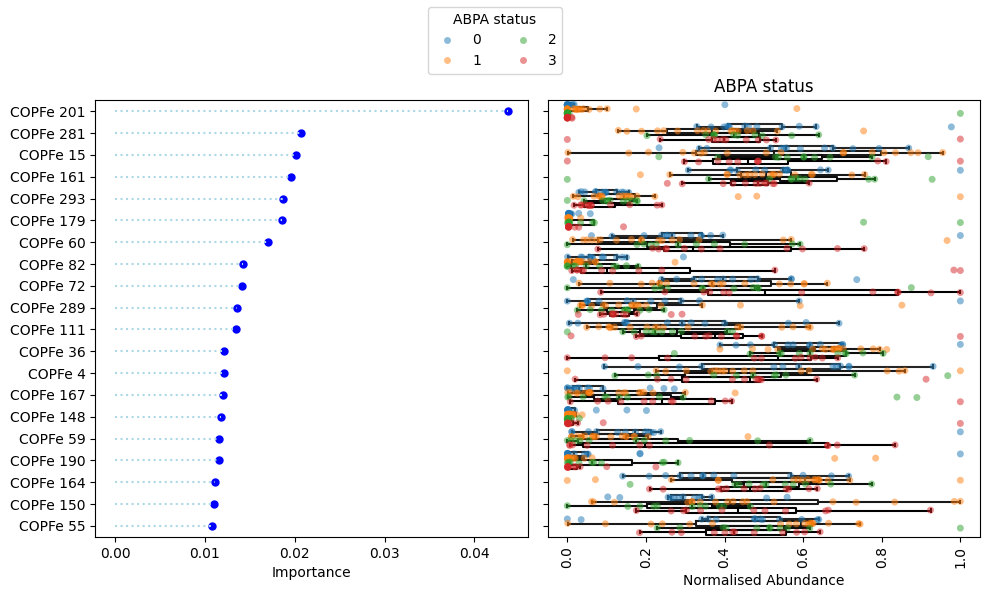

In [6]:
intcol = 'ABPA_status'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)

cf_analysis_lib.plot_one_top_feature(merged_df, feature_importances_sorted, intcol, intcol_title, 
                                     custom_labels, 
                                     plot_legend=True)

## Run the GBRF

Next, on the binary data

The data for the classifier is {'no': 31, 'yes': 23} variables
We used 21 estimators for the random forest classifier
Mean squared error for ABPA_positive using classifier is 0.45454545454545453


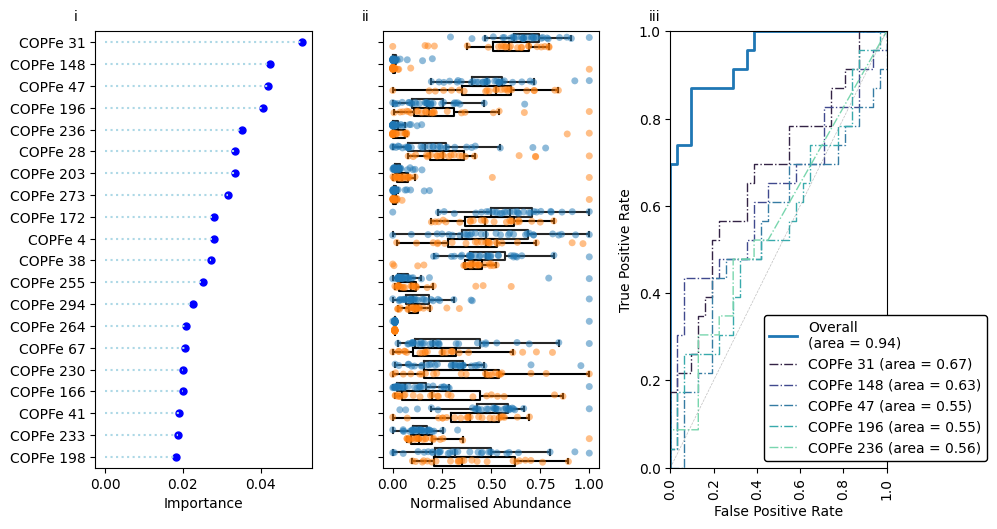

In [7]:
intcol = 'ABPA_positive'

intcol_title = replace_index.sub('', intcol).replace('_', ' ')
merged_df = pc_df.join(metadata[[intcol]]).dropna(subset=intcol)

categorical_data, custom_labels = cf_analysis_lib.create_custom_labels(metadata, intcol, merged_df)

X = merged_df.drop(intcol, axis=1)
y = merged_df[intcol]

if categorical_data:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_classifier_model(X, y, n_estimators=1000, n_iter_no_change=20)
  met = 'classifier'
else:
  model, mse, feature_importances_sorted = cf_analysis_lib.gb_regressor_model(X, y)
  met = 'regressor'

print(f"We used {model.n_estimators_} estimators for the random forest {met}", file=sys.stderr)
print(f"Mean squared error for {intcol} using {met} is {mse}", file=sys.stderr)
fig, axes = cf_analysis_lib.plot_importance_abundance_roc(merged_df, feature_importances_sorted, intcol, intcol_title, model,
                                     custom_labels, plot_legend=False)

labels = [cf_analysis_lib.int2roman(i+1) for i in range(3)] # this makes the labels roman numerals
for ax, label in zip(axes, labels):
    ax.text(-0.1, 1.05, label, transform=ax.transAxes,
            fontsize=10, va='top', ha='left')
    ax.set_title("")
plt.savefig('final_images/figS6.png', dpi=300)
plt.savefig('final_images/figS6.svg')
print()

In [8]:
cluster_assignments[cluster_assignments['Feature'].str.lower().str.contains('asper')]

,COPFe,Feature
1913,253,Aspergillaceae


In [9]:
cluster_assignments[cluster_assignments['COPFe']==47]

,COPFe,Feature
141,47,DNA Repair Base Excision
142,47,Repair of Iron Centers


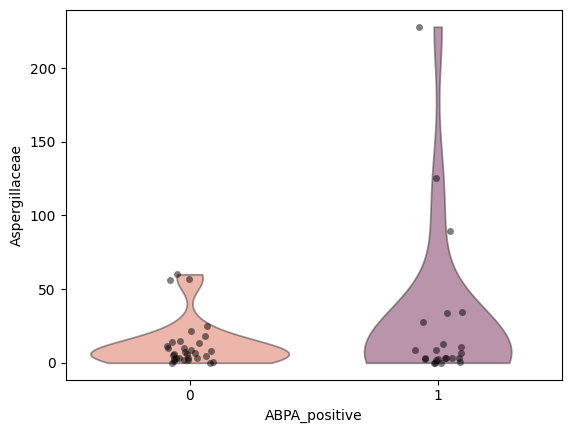

In [10]:
intcol = 'ABPA_positive'
merged = df.join(metadata[[intcol]], how='inner').dropna(subset=intcol)
g = sns.violinplot(x=intcol, y='Aspergillaceae', data=merged, hue=intcol, palette='rocket_r', alpha=0.5, legend=False, inner=None, density_norm='count', common_norm=True, cut=0)
g = sns.stripplot(x=intcol, y='Aspergillaceae', data=merged, color='black', jitter=True, alpha=0.5,  legend=False)

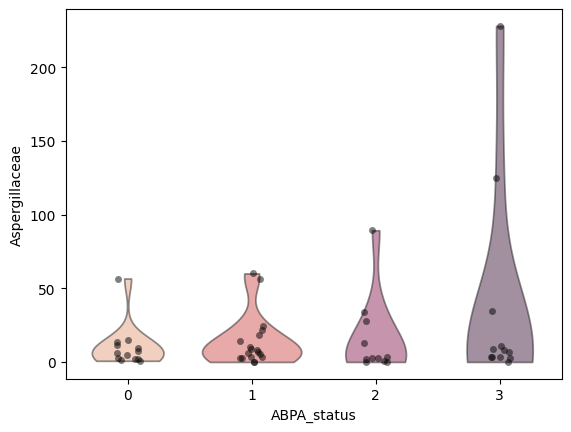

In [11]:
intcol = 'ABPA_status'
merged = df.join(metadata[[intcol]], how='inner').dropna(subset=intcol)
g = sns.violinplot(x=intcol, y='Aspergillaceae', data=merged, hue=intcol, palette='rocket_r', alpha=0.5, legend=False, inner=None, density_norm='count', common_norm=True, cut=0)
g = sns.stripplot(x=intcol, y='Aspergillaceae', data=merged, color='black', jitter=True, alpha=0.5,  legend=False)